# Classifiez automatiquement des biens de consommation - Cleaning & Preprocessing

Pascaline Grondein

Début : 04/07/2022

<i/>Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.</i>

<i/>Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.</i>

<i/>Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.</i>

<i/>Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.</i>

### Table of Contents

* [I. Exploratory Data Analysis](#chapter1)
    * [1. First Tour](#section_1_1)
        * [1. Display](#section_1_1_1)
        * [2. Structure, Nan, duplicated values](#section_1_1_2)
    * [2. Analysis](#section_1_2)
    * [3. Exploration](#section_1_3)
* [II. Text Cleaning](#chapter2)
    * [1. One document](#section_2_1)
        * [1. Lower](#section_2_1_1)
        * [2. Expand contractions](#section_2_1_2)
        * [3. Noise removal](#section_2_1_3)
        * [4. Punctuation removal](#section_2_1_4)
        * [5. Number removal](#section_2_1_5)
    * [2. Function on full corpus](#section_2_2)
* [III. Text Preprocessing](#chapter3)
    * [1. One document](#section_3_1)
        * [1. Tokenization](#section_3_1_1)
        * [2. Stopwords](#section_3_1_2)
        * [3. Stemming](#section_3_1_3)
        * [4. Lemmatization](#section_3_1_4)
    * [2. Function on full corpus](#section_3_2)
    * [3. Wordcloud](#section_3_3)

# Import

In [50]:
import os, sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import csv

import nltk
import contractions
import re
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from wordcloud import WordCloud
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [51]:
#download

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

#!pip install contractions

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pgron\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pgron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pgron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pgron\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pgron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Graphics and options

In [52]:
sns.set()
pd.set_option('display.max_colwidth', None)

# Data 

In [53]:
path = 'C:/Users/pgron/Jupyter/P6/data/source/'
fn = path + 'flipkart_com-ecommerce_sample_1050.csv'

In [54]:
df = pd.read_csv(fn)

# <a class="anchor" id="chapter1">I. Exploratory Data Analysis</a>

In [55]:
def def_pd(df, df_name) : #function to explore dataset
    
    #STRUCTURE
    display(df.info())
    print('--- Unique values ---')
    display(df.nunique())
    
    #NaN
    #Calcul du pct de valeurs manquantes total
    row = df.shape[0]
    col = df.shape[1]
    nb_val = row * col
    nb_val_manqu = df.isnull().sum().sum()
    val_manq_pct = round((nb_val_manqu/nb_val)*100, 3)
    
    #Calcul du pourcentage de valeurs manquantes par variables
    index = df.index
    nb_na = df.isnull().mean()
    pct_remplissage = pd.DataFrame((100 - (nb_na*100)).astype(int), 
                                   columns = ['Pourcentage de remplissage (%)'])
    print('--- Nan & Duplicated ---')
    print('   ')
    print('Le fichier {} comporte {} lignes et {} colonnes,' 
          ' ainsi que {} valeurs manquantes sur {} entrées ({} %).'.format(df_name, row,
                                                                           col, nb_val_manqu, nb_val, val_manq_pct))
    print('   ')
    display(pct_remplissage)
    print('   ')
    
    #DOUBLONS
    dup = df.duplicated().sum()
    print('   ')
    print('Le dataframe comporte', dup, 'doublons globaux.')
    print('   ')
    
    for col in df.columns :
        n = df.duplicated(subset = col).sum()
        print(f'col : {col} -> duplicated : {n}')
    
    
    display(df.describe(include = np.number))
    display(df.describe(include = object))

In [56]:
def boxplot(df,x_lim):
    
    boxprops = dict(linestyle='-', linewidth=1, color='k')
    medianprops = dict(linestyle='-', linewidth=1, color='k')
    meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    sns.set_style("whitegrid")

    num_ = list(df.select_dtypes('float'))

    for i in range(0,len(num_)) :
            
        plt.figure(figsize=(10, 8))
    
        df.boxplot(column = num_[i], boxprops = boxprops, showfliers=True, 
                    medianprops=medianprops, vert=False, patch_artist=True, 
                    showmeans=True, meanprops=meanprops)
        plt.title(num_[i], fontsize = 30)
        plt.xlim(0, x_lim[i])
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel('', fontsize = 25)
        plt.ylabel('', fontsize = 25)

    plt.show()

In [57]:
def histo(df, var, b, cumulative, x, y):

    plt.figure(figsize = (10, 6))
    
    if cumulative == 1 :
        df[var].value_counts().hist(density = True, bins=b, cumulative = -1)
    else :
        df[var].value_counts().hist(density = True, bins=b, cumulative = False)
        
    plt.xlim(0, x)
    plt.ylim(0, y)
    plt.title(var,fontsize = 30)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('', fontsize = 25)
    plt.ylabel('', fontsize = 25)

    plt.show()

In [92]:
def pie(df, var, lim):
    
    
    df_plot = pd.DataFrame(df[var].value_counts(normalize = True))
    df_plot = df_plot.rename(columns = {var :'Frequence' })
    df_plot_1 = df_plot.loc[df_plot['Frequence'] > lim]
    
    plot = df_plot_1.plot(kind='pie', y = 'Frequence', autopct ='%1.0f%%', figsize=(10, 10), 
                          fontsize = 25, legend = False, labeldistance = 1.1)
                                                     

    plot.set_title(var,fontsize = 40)
    plt.title(var,fontsize = 30)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('equal') 
    plt.show()
    
    pct = pd.DataFrame(data = df[var].value_counts()).rename(columns = {var :'Nb Users' })
    pct['% users'] = round((pct['Nb Users']/len(df))*100, 2)
    
    display(pct)

## <a class="anchor" id="section_1_1">1. First Tour</a>

### <a class="anchor" id="section_1_1_1">1. Display</a>

In [58]:
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"",

In [59]:
df.tail(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-large-self-adhesive-sticker/p/itme88zgzgcvtbpx?pid=STIE88ZGTX65GH4V,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >> Oren Empower Stickers""]",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,"Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n Price: Rs. 999\r\n\t\t\t\t\r\n\t\t\tDouble sticker can be used for the big walls. Two pieces is there that can be arranged alternatively or reflectively. This will d�cor the wall like 3d look. Tree with the green shaded leaves will give the sharp feature of the greenery. Reusable i.e. Can be used again after applied once. Simple remove and re-use the sticker on same or another wall with a different idea\r\n\r\nHow to install?\r\n\r\n1) The surface you wish to attach your decal must be clean \r\nand free from dust, grease or any other contamination.\r\n \r\n2) Simply peel those pre-cut pieces of wall stickers off from \r\nbacking paper and apply them on the desired area.\r\nNOTE: \r\n1. Freshly painted or lacquered \r\nsurfaces must be allowed to completely cure before the decal is applied. We \r\nrecommend waiting for minimum of 2-3 weeks. 2. \r\nWe discourage installation on certain surfaces such as brick, stucco, concrete \r\nblock, suede paints, and sand paints. 3. Do not apply \r\non wet walls\r\n3) Press firmly to squeeze out any air bubbles.\r\nNote: It will be helpful and fun \r\nif you take help of your friends or family members to stick the wall decals on your \r\nwall and please Do not apply on wet walls.\r\nDouble sticker can be used for the big walls. Two pieces is there that can be arranged alternatively or reflectively. This will d�cor the wall like 3d look. Tree with the green shaded leaves will give the sharp feature of the greenery. Reusable i.e. Can be used again after applied once. Simple remove and re-use the sticker on same or another wall with a different idea\r\n\r\nHow to install?\r\n\r\n1) The surface you wish to attach your decal must be clean \r\nand free from dust, grease or any other contamination.\r\n \r\n2) Simply peel those pre-cut pieces of wall stickers off from \r\nbacking paper and apply them on the desired area.\r\nNOTE: \r\n1. Freshly painted or lacquered \r\nsurfaces must be allowed to completely cure before the decal is applied. We \r\nrecommend waiting for minimum of 2-3 weeks. 2. \r\nWe discourage installation on certain surfaces such as brick, stucco, concrete \r\nblock, suede paints, and sand paints. 3. Do not apply \r\non wet walls\r\n3) Press firmly to squeeze out any air bubbles.\r\nNote: It will be helpful and fun \r\nif you take help of your friends or family members to stick the wall decals on your \r\nwall and please Do not apply on wet walls.",No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""Sheet Containing Set of Small Stickers""}, {""key""=>""Ideal Use"", ""value""=>""Any place where there is need of ample decoration""}, {""key""=>""Brand"", ""value""=>""Oren Empower""}, {""key""=>""Acid Free"", ""value""=>""No""}, {""key""=>""Type"", ""value""=>""Self Adhesive""}, {""key""=>""Size in Number"", ""value""=>""90 cm""}, {""key""=>""Material"", ""value""=>""PVC Vinyl""}, {""key""=>""Lamination Type"", ""value""=>""Gloss""}, {""key""=>""Design"", ""value""=>""Environmental graphic design""}, {""key""=>""Transfer Paper"", ""value""=>""No""}, {""key""=>""Scratch-resistant"", ""value""=>""No""}, {""key""=>""Shape"", ""value""=>""Rectangular""}, {""key""=>""Laminated"", ""value""=>""Yes""}, {""key""=>

In [60]:
df.sample(20)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
900,d3f4a4336324a3d180de23df1e75b9b7,2016-05-22 10:35:27 +0000,http://www.flipkart.com/loreal-diarichesse-no-5-light-brown-pack-3-with-20-6-developer-hair-color/p/itmegvr9fau6jyyk?pid=HRCEGVR9HBWKYFPD,Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )With 20 Vol 6 % Developer Hair Color,"[""Beauty and Personal Care >> Hair Care >> Hair Colors >> Loreal Hair Colors >> Loreal Diarichesse No- 5 Light Brown ( Pack of 3...""]",HRCEGVR9HBWKYFPD,4295.0,3295.0,d3f4a4336324a3d180de23df1e75b9b7.jpg,False,"Key Features of Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )With 20 Vol 6 % Developer Hair Color Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )50 ml Each With 20 Vol 6 % Developer 1000 mL A tone on tone color to cover white hair up to 70%! With deep reflexes and exceptional smoothness. Pastel toning of bleached and highlighted hair It is an ammonia-free color service that enhances the natural color of the hair with radiant and bright reflections.,Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )With 20 Vol 6 % Developer Hair Color (Brown) Price: Rs. 3,295 Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )50 ml Each With 20 Vol 6 % Developer 1000 mL A tone on tone color to cover white hair up to 70%! With deep reflexes and exceptional smoothness.Pastel toning of bleached and highlighted hairIt is an ammonia-free color service that enhances the natural color of the hair with radiant and bright reflections.,Specifications of Loreal Diarichesse No- 5 Light Brown ( Pack of 3 )With 20 Vol 6 % Developer Hair Color (Brown) Hair Color Traits Ammonia Free Yes General Traits Quantity 1150 ml Ideal For Men, Women Container Type Bottle Color Brown In the Box 1 Developer, 3 Tube",No rating available,No rating available,Loreal,"{""product_specification""=>[{""key""=>""Ammonia Free"", ""value""=>""Yes""}, {""key""=>""Quantity"", ""value""=>""1150 ml""}, {""key""=>""Ideal For"", ""value""=>""Men, Women""}, {""key""=>""Container Type"", ""value""=>""Bottle""}, {""key""=>""Color"", ""value""=>""Brown""}, {""value""=>""1 Developer, 3 Tube""}]}"
468,948699ab8c947ce56c256f9cf7996761,2016-04-16 13:01:18 +0000,http://www.flipkart.com/tks-cotton-hair-towel/p/itmehqvq7zkucjzm?pid=BTWEHQVQ5VBYE54K,Tks Cotton Hair Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Tks Baby Bath Towels >> Tks Cotton Hair Towel (1 Hair towel, Orange)""]",BTWEHQVQ5VBYE54K,70.0,70.0,948699ab8c947ce56c256f9cf7996761.jpg,False,"Key Features of Tks Cotton Hair Towel Size: Medium Height: 56 inch GSM: 30 Usage: Daily Use,Specifications of Tks Cotton Hair Towel (1 Hair towel, Orange) Bath Towel Features Machine Washable Yes Material Cotton Design Checks General Brand Tks Type Hair Towel GSM 30 Model Name HAIR CARE Ideal For Women, Girls Model ID DSCO 125 Color Orange Size Medium Dimensions Length 56 inch Width 26 inch In the Box Sales Package 1 Hair towel",No rating available,No rating available,Tks,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Checks""}, {""key""=>""Brand"", ""value""=>""Tks""}, {""key""=>""Type"", ""value""=>""Hair Towel""}, {""key""=>""GSM"", ""value""=>""30""}, {""key""=>""Model Name"", ""value""=>""HAIR CARE""}, {""key""=>""Ideal For"", ""value""=>""Women, Girls""}, {""key""=>""Model ID"", ""value""=>""DSCO 125""}, {""key""=>""Color"", ""value""=>""Orange""}, {""key""=>""Size"", ""value""=>""Medium""}, {""key""=>""Length"", ""value""=>""56 inch""}, {""key""=>""Width"", ""value""=>""26 inch""}, {""key""=>""Sales Package"", ""value""=>""1 Hair towel""}]}"
557,1fcff864d6e397e1424d5366e6c6b8fa,2016-01-07 05:50:25 +0000,http://www.flipkart.com/hmt-sonata-gold-plated-watch-men-analog/p/itmdznshqxeauht8?pid=WATDZNSHJHDTS9GN,HMT Son

### <a class="anchor" id="section_1_1_2">2. Structure, Nan, duplicated values</a>

In [61]:
def_pd(df,'data')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

None

--- Unique values ---


uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

--- Nan & Duplicated ---
   
Le fichier data comporte 1050 lignes et 15 colonnes, ainsi que 341 valeurs manquantes sur 15750 entrées (2.165 %).
   


,Pourcentage de remplissage (%)
uniq_id,100
crawl_timestamp,100
product_url,100
product_name,100
product_category_tree,100
pid,100
retail_price,99
discounted_price,99
image,100
is_FK_Advantage_product,100


   
   
Le dataframe comporte 0 doublons globaux.
   
col : uniq_id -> duplicated : 0
col : crawl_timestamp -> duplicated : 901
col : product_url -> duplicated : 0
col : product_name -> duplicated : 0
col : product_category_tree -> duplicated : 408
col : pid -> duplicated : 0
col : retail_price -> duplicated : 695
col : discounted_price -> duplicated : 625
col : image -> duplicated : 0
col : is_FK_Advantage_product -> duplicated : 1048
col : description -> duplicated : 0
col : product_rating -> duplicated : 1023
col : overall_rating -> duplicated : 1023
col : brand -> duplicated : 559
col : product_specifications -> duplicated : 65


,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Mug""}, {""key""=>""Mug Capacity"", ""value""=>""5.5 l""}, {""key""=>""Freezer Safe"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Ceramic""}, {""key""=>""Microwave Safe"", ""value""=>""Yes""}, {""value""=>""1 Year Rockmantra Brand Warranty and Free Transit Insurance.""}, {""key""=>""Diameter"", ""value""=>""88 mm""}, {""key""=>""Weight"", ""value""=>""300 g""}, {""key""=>""Height"", ""value""=>""101 mm""}, {""key""=>""Width"", ""value""=>""88 mm""}, {""key""=>""Sales Package"", ""value""=>""1 mug""}]}"
freq,1,150,1,1,56,1,1,1,889,889,11,22


Plusieurs remarques : 

 - unique_id : à utiliser comme index
 - pas de valeurs dupliquées dans description, ni image
 - retail_price & discounted_price : entre 35 et 201 000 ==> outliers?
 - true label : product_category_tree, 7 catégories
 - product name 

Colonnes intéressantes pour nous pour la partie texte :

 - unique_id
 - product_name
 - product_category_tree
 - description
 
Pas de valeurs manquantes ni de doublons, pas besoin de phase de nettoyage.

## <a class="anchor" id="section_1_2">2. Analysis</a>

Regardons la distribution des prix.

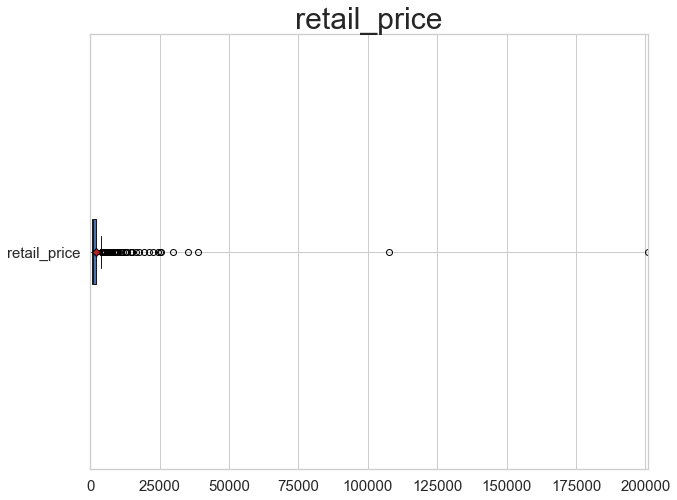

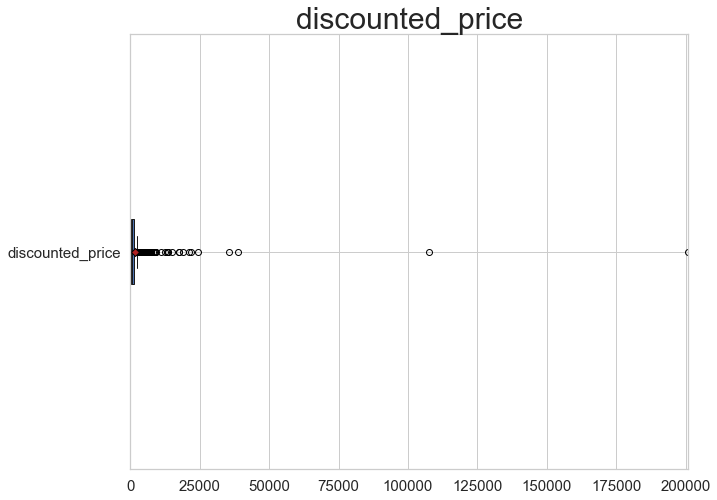

In [62]:
x_lim = [201000, 201000]
boxplot(df,x_lim)

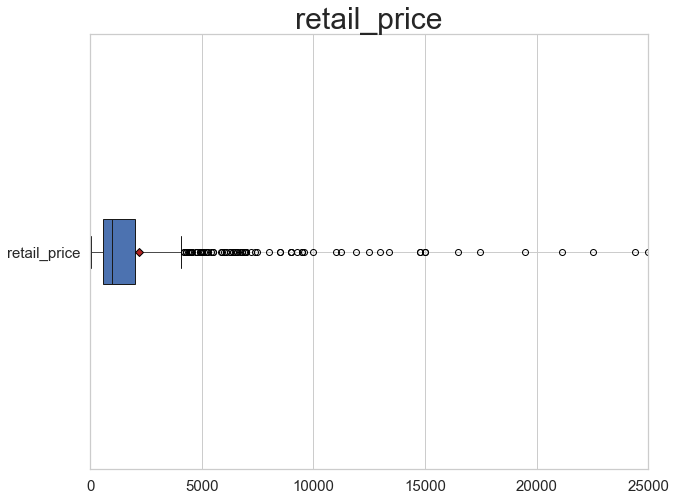

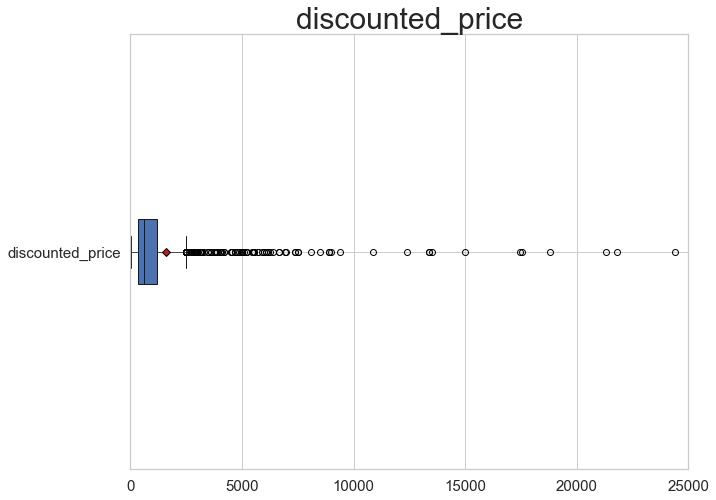

In [63]:
x_lim = [25000, 25000]
boxplot(df,x_lim)

Regardons la longueur des descriptions.

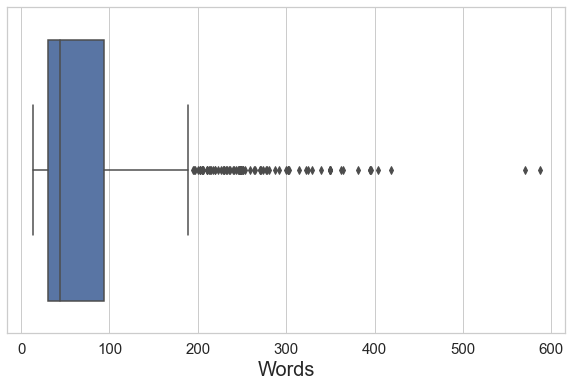

In [69]:
tmp = df.description.apply(lambda x: len(x.split()))

plt.figure(figsize = (10, 6))
sns.boxplot(tmp)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('', fontsize = 20)

plt.show()

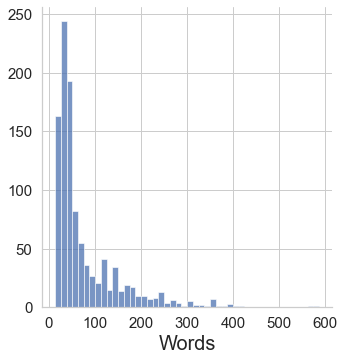

In [70]:
sns.displot(tmp)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('', fontsize = 20)

plt.show()

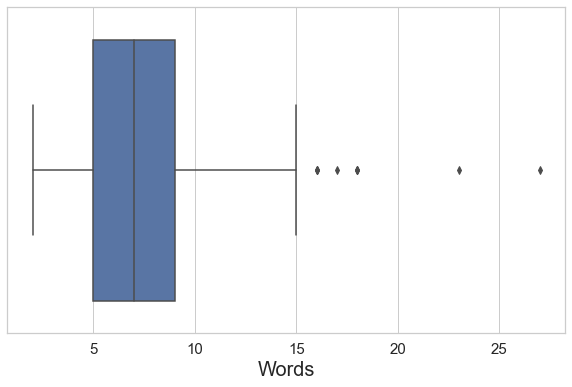

In [73]:
tmp = df.product_name.apply(lambda x: len(x.split()))

plt.figure(figsize = (10, 6))
sns.boxplot(tmp)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('', fontsize = 20)

plt.show()

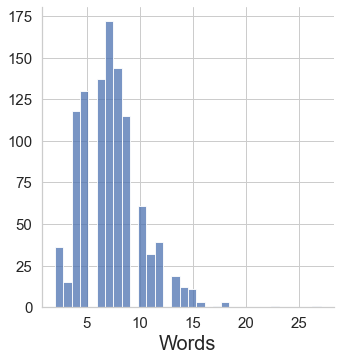

In [74]:
sns.displot(tmp)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('', fontsize = 20)

plt.show()

## <a class="anchor" id="section_1_3">3. Column selection</a>

In [77]:
cols_txt = ['uniq_id','product_name','product_category_tree','description']
df_txt = df[cols_txt]
#df_txt
cols_image = ['uniq_id', 'product_category_tree', 'image']
df_image = df[cols_image]

In [78]:
#true_label creation
term1 = df_txt['product_category_tree'].str.split(' ').str.get(0)
term2 = df_txt['product_category_tree'].str.split(' ').str.get(1)
df_txt['true_label'] = term1 + str(' ') + term2
df_txt['true_label'] = df_txt['true_label'].str.replace('[["&>]','')
df_txt = df_txt.drop('product_category_tree', axis = 1)

term1 = df_image['product_category_tree'].str.split(' ').str.get(0)
term2 = df_image['product_category_tree'].str.split(' ').str.get(1)
df_image['true_label'] = term1 + str(' ') + term2
df_image['true_label'] = df_image['true_label'].str.replace('[["&>]','')
df_image = df_image.drop('product_category_tree', axis = 1)

#df_txt.head()
df_image.head(1)

,uniq_id,image,true_label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing


In [79]:
#concat description + product_name = txt
df_txt['txt'] = df_txt['product_name'] + str(' ') + df_txt['description'] 
#df_txt = df_txt.drop(['description'], axis = 1)

In [80]:
df_txt.to_csv('data/source/df_txt.csv', index = False)
df_image.to_csv('data/source/df_image.csv', index = False)

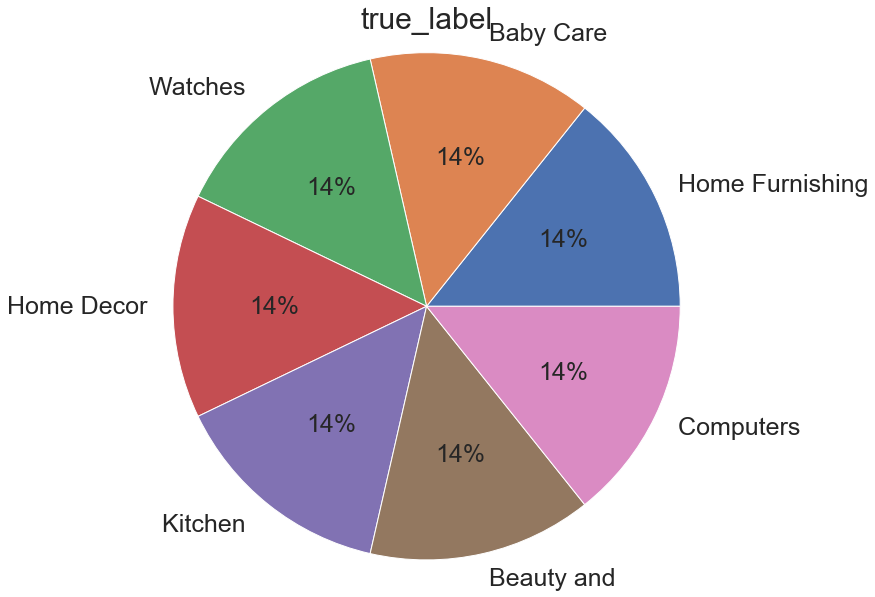

,Nb Users,% users
Home Furnishing,150,14.29
Baby Care,150,14.29
Watches,150,14.29
Home Decor,150,14.29
Kitchen,150,14.29
Beauty and,150,14.29
Computers,150,14.29


In [93]:
pie(df_txt, 'true_label', 0)

# <a class="anchor" id="chapter2">II. Text cleaning</a>

##  <a class="anchor" id="section_2_1">1. One document</a>

In [21]:
df_txt.head()

,uniq_id,product_name,description,true_label,txt
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester"
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",Baby Care,"Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of

In [22]:
doc = df_txt.txt.sample(1)
doc = doc.values[0]
doc

'Escort E-1700-906_Blk Analog Watch  - For Men, Boys Escort E-1700-906_Blk Analog Watch  - For Men, Boys\r\n                         Price: Rs. 1,829\r\n\t\t\t\t\r\n\t\t\tIf you have it, flaunt it! If this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of Escort. The casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nIf you have it, flaunt it! If this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of Escort. The casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

### <a class="anchor" id="section_2_1_1">1. Lower</a>

In [23]:
doc = doc.lower()
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

### <a class="anchor" id="section_2_1_2">2. Expand the contractions</a>

In [24]:
doc = contractions.fix(doc)
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

### <a class="anchor" id="section_2_1_3">3. Noise removal</a>

#### Remove urls

In [25]:
doc = re.sub(r"https?://\S+|www\.\S+|.com", "", doc) #separate w/ \S+|
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

#### Remove HTML tags

In [26]:
html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
doc = re.sub(html, "", doc)
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

#### Remove Non-ASCI

In [27]:
doc = re.sub(r'[^\x00-\x7f]',r'', doc)
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

#### Remove special characters

In [28]:
emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
doc = emoji_pattern.sub(r'', doc)
doc

'escort e-1700-906_blk analog watch  - for men, boys escort e-1700-906_blk analog watch  - for men, boys\r\n                         price: rs. 1,829\r\n\t\t\t\t\r\n\t\t\tif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.\r\nif you have it, flaunt it! if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort. the casing adds more appeal to this timepiece that can be worn on a rainy day, all thanks to its water resistance upto 10 atm.'

### <a class="anchor" id="section_2_1_4">4. Punctuation removal</a>

In [29]:
doc = doc.translate(str.maketrans('', '', string.punctuation))
doc

'escort e1700906blk analog watch   for men boys escort e1700906blk analog watch   for men boys\r\n                         price rs 1829\r\n\t\t\t\t\r\n\t\t\tif you have it flaunt it if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort the casing adds more appeal to this timepiece that can be worn on a rainy day all thanks to its water resistance upto 10 atm\r\nif you have it flaunt it if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort the casing adds more appeal to this timepiece that can be worn on a rainy day all thanks to its water resistance upto 10 atm'

### <a class="anchor" id="section_2_1_5">5. Number removal</a>

In [30]:
doc = ''.join([i for i in doc if not i.isdigit()])
doc

'escort eblk analog watch   for men boys escort eblk analog watch   for men boys\r\n                         price rs \r\n\t\t\t\t\r\n\t\t\tif you have it flaunt it if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort the casing adds more appeal to this timepiece that can be worn on a rainy day all thanks to its water resistance upto  atm\r\nif you have it flaunt it if this is your mantra then hit the streets in style wearing this black coloured analog watch for men from the house of escort the casing adds more appeal to this timepiece that can be worn on a rainy day all thanks to its water resistance upto  atm'

##  <a class="anchor" id="section_2_2">2. Function on full corpus</a>

In [31]:
def txt_cleaning(corp,var, clean_var) :
    
    
    #LOWER
    corp[clean_var] = corp[var].apply(lambda x: x.lower())
    
    
    #EXPAND CONTRACTIONS
    corp[clean_var] = corp[clean_var].apply(lambda x: contractions.fix(x))
    
    
    #NOISE REMOVAL
        #urls
    corp[clean_var] = corp[clean_var].apply(lambda x: re.sub(r"https?://\S+|www\.\S+|.com", "", x))
    
        #HTML
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    corp[clean_var] = corp[clean_var].apply(lambda x: re.sub(html, "", x))
    
        #Non-Asci
    corp[clean_var] = corp[clean_var].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x))
    
        #Special characters
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    corp[clean_var] = corp[clean_var].apply(lambda x: emoji_pattern.sub(r'', x))
    
    
    #PUNCTUATION REMOVAL
    corp[clean_var] = corp[clean_var].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    
    #NUMBER REMOVAL
    corp[clean_var] = corp[clean_var].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    
    
    return corp

In [32]:
df_txt_cleaned = txt_cleaning(df_txt,'txt', 'txt_clean')
df_txt_cleaned = txt_cleaning(df_txt,'product_name', 'pn_clean')
df_txt_cleaned = txt_cleaning(df_txt,'description', 'desc_clean')
df_txt_cleaned = df_txt_cleaned.drop(['product_name', 'description','txt'], axis = 1)
df_txt_cleaned.to_csv('data/cleaned/df_txt_cleaned.csv', index = False)
df_txt_cleaned.head(1)

,uniq_id,true_label,txt_clean,pn_clean,desc_clean
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm in height pack of price rs this curtain enhances the look of the interiorsthis curtain is made from high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to wee the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlightspecifications of elegance polyester multicolor abstract eyelet door curtain cm in height pack of general brand elegance designed for door type eyelet model name abstract polyester door curtain set of model id duster color multicolor dimensions length cm in the box number of contents in sales package pack of sales package curtains body design material polyester,elegance polyester multicolor abstract eyelet door curtain,key features of elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm in height pack of price rs this curtain enhances the look of the interiorsthis curtain is made from high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to wee the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlightspecifications of elegance polyester multicolor abstract eyelet door curtain cm in height pack of general brand elegance designed for door type eyelet model name abstract polyester door curtain set of model id duster color multicolor dimensions length cm in the box number of contents in sales package pack of sales package curtains body design material polyester


#  <a class="anchor" id="chapter3">III. Text Preprocessing</a>

##  <a class="anchor" id="section_3_1">1. One document</a>

In [33]:
doc = df_txt_cleaned.txt_clean.sample(1)
doc = doc.values[0]
doc

'rmshoppee mdf wall shelf key features of rmshoppee mdf wall shelf trendy  stylish easy to assemblermshoppee mdf wall shelf number of shelves   black price rs  this h shape wall shelf will increase decoration of your walls you can use it as book shelf  dvd shelf or can keep show pieces on it specifications of rmshoppee mdf wall shelf number of shelves   black general brand rmshoppee suitable for living room  bedroom model number rm material mdf color black body  design features number of shelves  in the box sales package  shelf additional features other features screw included'

### <a class="anchor" id="section_3_1_1">1. Tokenization</a>

In [34]:
tokens = word_tokenize(doc)
tokens

['rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'key',
 'features',
 'of',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'trendy',
 'stylish',
 'easy',
 'to',
 'assemblermshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'of',
 'shelves',
 'black',
 'price',
 'rs',
 'this',
 'h',
 'shape',
 'wall',
 'shelf',
 'will',
 'increase',
 'decoration',
 'of',
 'your',
 'walls',
 'you',
 'can',
 'use',
 'it',
 'as',
 'book',
 'shelf',
 'dvd',
 'shelf',
 'or',
 'can',
 'keep',
 'show',
 'pieces',
 'on',
 'it',
 'specifications',
 'of',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'of',
 'shelves',
 'black',
 'general',
 'brand',
 'rmshoppee',
 'suitable',
 'for',
 'living',
 'room',
 'bedroom',
 'model',
 'number',
 'rm',
 'material',
 'mdf',
 'color',
 'black',
 'body',
 'design',
 'features',
 'number',
 'of',
 'shelves',
 'in',
 'the',
 'box',
 'sales',
 'package',
 'shelf',
 'additional',
 'features',
 'other',
 'features',
 'screw',
 'included']

In [35]:
#token unique
len(set(tokens))

60

### <a class="anchor" id="section_3_1_2">2. Stopwords</a>

In [36]:
stop_words = set(stopwords.words('english'))
print(stop_words) #list de stop_words de nltk

{'after', 'o', 'weren', 'ain', "needn't", 'so', 'doesn', 'but', 'there', 'yourselves', 'that', 'wasn', 'me', 'further', 'whom', "should've", 'now', 'why', 'am', "aren't", 's', 'against', 'an', "that'll", 'where', 'don', 'been', 'him', 'hadn', 'll', 'our', 'most', 'y', 'how', 'its', "haven't", 'i', 'aren', 'have', 'those', 'about', 'ma', 'does', 'his', 'both', 'before', 'yourself', 'from', 'not', 'these', 'yours', 'hers', 'didn', 'your', "wouldn't", 'which', 'shan', 'of', 'at', 'when', 'were', 'on', "you're", 'it', 'into', 'won', 'we', 'between', 'with', 'once', 'being', 'same', 'shouldn', 'own', 'd', 'is', 'did', 'mightn', 'more', 'no', 'herself', 'be', 'because', 'too', 'my', 'just', 'was', 'who', 'has', "hasn't", 'under', 're', 'themselves', 'himself', 'as', 'wouldn', 'few', 'over', 'ours', 't', 'below', 'or', 'down', "doesn't", "didn't", 'during', 'all', 'her', 'such', 'for', 'out', 'their', 'ourselves', 'you', 'theirs', "you'll", 'each', "you'd", 'in', "shouldn't", 'needn', 'she', 

In [37]:
tokens = [w for w in tokens if w not in stop_words]
tokens

['rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'key',
 'features',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'trendy',
 'stylish',
 'easy',
 'assemblermshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelves',
 'black',
 'price',
 'rs',
 'h',
 'shape',
 'wall',
 'shelf',
 'increase',
 'decoration',
 'walls',
 'use',
 'book',
 'shelf',
 'dvd',
 'shelf',
 'keep',
 'show',
 'pieces',
 'specifications',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelves',
 'black',
 'general',
 'brand',
 'rmshoppee',
 'suitable',
 'living',
 'room',
 'bedroom',
 'model',
 'number',
 'rm',
 'material',
 'mdf',
 'color',
 'black',
 'body',
 'design',
 'features',
 'number',
 'shelves',
 'box',
 'sales',
 'package',
 'shelf',
 'additional',
 'features',
 'features',
 'screw',
 'included']

In [38]:
#token unique
len(set(tokens))

45

### <a class="anchor" id="section_3_1_3">3. Lemmatization</a>

In [39]:
lem = WordNetLemmatizer()
lems = [lem.lemmatize(i) for i in tokens]
lems

['rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'key',
 'feature',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'trendy',
 'stylish',
 'easy',
 'assemblermshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelf',
 'black',
 'price',
 'r',
 'h',
 'shape',
 'wall',
 'shelf',
 'increase',
 'decoration',
 'wall',
 'use',
 'book',
 'shelf',
 'dvd',
 'shelf',
 'keep',
 'show',
 'piece',
 'specification',
 'rmshoppee',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelf',
 'black',
 'general',
 'brand',
 'rmshoppee',
 'suitable',
 'living',
 'room',
 'bedroom',
 'model',
 'number',
 'rm',
 'material',
 'mdf',
 'color',
 'black',
 'body',
 'design',
 'feature',
 'number',
 'shelf',
 'box',
 'sale',
 'package',
 'shelf',
 'additional',
 'feature',
 'feature',
 'screw',
 'included']

In [40]:
len(set(lems))

43

### <a class="anchor" id="section_3_1_4">4. Stemming</a>

In [41]:
stemmer = nltk.PorterStemmer()
stems = [stemmer.stem(i) for i in lems]
stems

['rmshoppe',
 'mdf',
 'wall',
 'shelf',
 'key',
 'featur',
 'rmshoppe',
 'mdf',
 'wall',
 'shelf',
 'trendi',
 'stylish',
 'easi',
 'assemblermshoppe',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelf',
 'black',
 'price',
 'r',
 'h',
 'shape',
 'wall',
 'shelf',
 'increas',
 'decor',
 'wall',
 'use',
 'book',
 'shelf',
 'dvd',
 'shelf',
 'keep',
 'show',
 'piec',
 'specif',
 'rmshoppe',
 'mdf',
 'wall',
 'shelf',
 'number',
 'shelf',
 'black',
 'gener',
 'brand',
 'rmshoppe',
 'suitabl',
 'live',
 'room',
 'bedroom',
 'model',
 'number',
 'rm',
 'materi',
 'mdf',
 'color',
 'black',
 'bodi',
 'design',
 'featur',
 'number',
 'shelf',
 'box',
 'sale',
 'packag',
 'shelf',
 'addit',
 'featur',
 'featur',
 'screw',
 'includ']

In [42]:
len(set(stems))

43

##  <a class="anchor" id="section_3_2">2. Function on full corpus</a>

In [43]:
def txt_preprocessing(corp, var, lem_or_stem, min_len_word, txt_or_token) :
    
    
    #TOKENIZATION
    corp['txt_tokenized'] = corp[var].apply(word_tokenize)
    
    #STOPWORDS
    stop = set(stopwords.words('english'))
    corp['tokens_no_stopwords'] = corp['txt_tokenized'].apply(lambda x: [w for w in x if w not in stop])
    
    #SHORT WORDS
    corp['tokens_no_short'] = corp['tokens_no_stopwords'].apply(lambda x: [w for w in x if len(w) >= min_len_word])
    
    #LEMMATIZATION
    if lem_or_stem == 'lem' : 
        lem = WordNetLemmatizer()
        corp['{}_lem'.format(var)] = corp['tokens_no_short'].apply(lambda x: [lem.lemmatize(i) for i in x])
        
        if txt_or_token == 'txt' : 
            corp['{}_lem'.format(var)] = [' '.join(map(str, l)) for l in corp['{}_lem'.format(var)]]
        
        corp = corp.drop(['txt_tokenized', 
                          'tokens_no_stopwords', 
                          'tokens_no_short'], axis = 1)
        corp = corp.drop(var, axis = 1)
        
    #STEMMING
    if lem_or_stem == 'stem' :
        stemmer = nltk.PorterStemmer()
        corp['{}_stem'.format(var)] = corp['tokens_no_short'].apply(lambda x: [stemmer.stem(i) for i in x])
        
        if txt_or_token == 'txt' :
            corp['{}_stem'.format(var)] = [' '.join(map(str, l)) for l in corp['{}_stem'.format(var)]]
        
        corp = corp.drop(['txt_tokenized', 
                          'tokens_no_stopwords', 
                           var,
                          'tokens_no_short'], axis = 1)
        
    #STEMMING & LEMMATIZATION
    if lem_or_stem == 'lem_stem' :
        
        lem = WordNetLemmatizer()
        corp['tokens_lem'] = corp['tokens_no_short'].apply(lambda x: [lem.lemmatize(i) for i in x])
        
        stemmer = nltk.PorterStemmer()
        corp['{}_lem_stem'.format(var)] = corp['tokens_lem'].apply(lambda x: [stemmer.stem(i) for i in x])
        
        if txt_or_token == 'txt' :
            corp['{}_lem_stem'.format(var)] = [' '.join(map(str, l)) for l in corp['{}_lem_stem'.format(var)]]
        
        corp = corp.drop(['txt_tokenized', 
                          'tokens_no_stopwords', 
                           var,
                          'tokens_no_short',
                          'tokens_lem'], axis = 1)       
    
    
    return corp

In [44]:
df_txt_cleaned = pd.read_csv('data/cleaned/df_txt_cleaned.csv')
df_cleaned_proc_lem = txt_preprocessing(df_txt_cleaned, var = 'txt_clean', 
                         lem_or_stem = 'lem', min_len_word = 3, txt_or_token = 'txt')
df_cleaned_proc_lem = txt_preprocessing(df_cleaned_proc_lem, var = 'pn_clean', 
                         lem_or_stem = 'lem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_lem = txt_preprocessing(df_cleaned_proc_lem, var = 'desc_clean', 
                         lem_or_stem = 'lem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_lem

,uniq_id,true_label,txt_clean_lem,pn_clean_lem,desc_clean_lem
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interiorsthis curtain made high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning wee bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster color multicolor dimension length box number content sale package pack sale package curtain body design material polyester,"[elegance, polyester, multicolor, abstract, eyelet, door, curtain]","[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, height, pack, price, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, feature, eyelet, style, stitch, metal, ringit, make, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, design, surreal, attention, sure, steal, heart, contemporary, eyelet, valance, curtain, slide, smoothly, draw, apart, first, thing, morning, wee, bright, sun, ray, want, wish, good, morning, whole, world, draw, close, evening, create, special, moment, joyous, beauty, given, soothing, print, bring, home, elegant, curtain, softly, filter, light, room, get, right, ...]"
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,sathiyas cotton bath towel specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men woman boy girl model asvtwl color red yellow blue size mediam dimension length inch width inch box number content sale package sale package bath towel,"[sathiyas, cotton, bath, towel]","[specification, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feature, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, asvtwl, color, red, yellow, blue, size, mediam, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,eurospa cotton terry face towel set key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings exclusively designed soft cotton towel export quality product soft texture take care skin give enriched feeling deserve eurospa exporting bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cm cmsspecifications eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvampcftsetassorted ideal boy girl men woman model shuvampcftsetassorted size smal

In [45]:
df_txt_cleaned = pd.read_csv('data/cleaned/df_txt_cleaned.csv')
df_cleaned_proc_stem = txt_preprocessing(df_txt_cleaned, var = 'txt_clean', 
                         lem_or_stem = 'stem', min_len_word = 3, txt_or_token = 'txt')
df_cleaned_proc_stem = txt_preprocessing(df_cleaned_proc_stem, var = 'pn_clean', 
                         lem_or_stem = 'stem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_stem = txt_preprocessing(df_cleaned_proc_stem, var = 'desc_clean', 
                         lem_or_stem = 'stem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_stem

,uniq_id,true_label,txt_clean_stem,pn_clean_stem,desc_clean_stem
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract eyelet door curtain floral curtaineleg polyest multicolor abstract eyelet door curtain height pack price curtain enhanc look interiorsthi curtain made high qualiti polyest fabricit featur eyelet style stitch metal ringit make room environ romant lovingthi curtain ant wrinkl anti shrinkag eleg apparanceg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn wee bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlightspecif eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model duster color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest,"[eleg, polyest, multicolor, abstract, eyelet, door, curtain]","[key, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtaineleg, polyest, multicolor, abstract, eyelet, door, curtain, height, pack, price, curtain, enhanc, look, interiorsthi, curtain, made, high, qualiti, polyest, fabricit, featur, eyelet, style, stitch, metal, ringit, make, room, environ, romant, lovingthi, curtain, ant, wrinkl, anti, shrinkag, eleg, apparanceg, home, bright, modernist, appeal, design, surreal, attent, sure, steal, heart, contemporari, eyelet, valanc, curtain, slide, smoothli, draw, apart, first, thing, morn, wee, bright, sun, ray, want, wish, good, morn, whole, world, draw, close, even, creat, special, moment, joyou, beauti, given, sooth, print, bring, home, eleg, curtain, softli, filter, light, room, get, right, ...]"
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,sathiya cotton bath towel specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl ye materi cotton design self design gener brand sathiya type bath towel gsm model name sathiya cotton bath towel ideal men women boy girl model asvtwl color red yellow blue size mediam dimens length inch width inch box number content sale packag sale packag bath towel,"[sathiya, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, featur, machin, washabl, ye, materi, cotton, design, self, design, gener, brand, sathiya, type, bath, towel, gsm, model, name, sathiya, cotton, bath, towel, ideal, men, women, boy, girl, model, asvtwl, color, red, yellow, blue, size, mediam, dimens, length, inch, width, inch, box, number, content, sale, packag, sale, packag, bath, towel]"
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,eurospa cotton terri face towel set key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri face towel set piec face towel set assort price eurospa bring exclus design soft cotton towel export qualiti product soft textur take care skin give enrich feel deserv eurospa export bath towel lot renown brand last year famou fine print absorb soft durabl note product cotton suscept shrinkag product color may vari pictur size may vari wash care wash cold water iron bleach flat dri wash first use size face towel cm cmsspecif eurospa cotton terri face towel set piec face towel set assort bath towel featur materi cotton terri design shuvam gener brand eurospa gsm type face towel set model name shuvampcftsetassort ideal boy girl men women model shuvampcftsetassort size small color assort dimens weight length inch width inch box number content sale packag sale packag piec face towel set,"[eurospa, cotton, terri, face, towel, set]","[key, featur, eurospa, cotton, terri, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, t

In [46]:
df_txt_cleaned = pd.read_csv('data/cleaned/df_txt_cleaned.csv')
df_cleaned_proc_lem_stem = txt_preprocessing(df_txt_cleaned, var = 'txt_clean', 
                         lem_or_stem = 'lem_stem', min_len_word = 3, txt_or_token = 'txt')
df_cleaned_proc_lem_stem = txt_preprocessing(df_cleaned_proc_lem_stem, var = 'pn_clean', 
                         lem_or_stem = 'lem_stem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_lem_stem = txt_preprocessing(df_cleaned_proc_lem_stem, var = 'desc_clean', 
                         lem_or_stem = 'lem_stem', min_len_word = 3, txt_or_token = 'token')
df_cleaned_proc_lem_stem

,uniq_id,true_label,txt_clean_lem_stem,pn_clean_lem_stem,desc_clean_lem_stem
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract eyelet door curtain floral curtaineleg polyest multicolor abstract eyelet door curtain height pack price curtain enhanc look interiorsthi curtain made high qualiti polyest fabricit featur eyelet style stitch metal ringit make room environ romant lovingthi curtain ant wrinkl anti shrinkag eleg apparanceg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn wee bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlightspecif eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model duster color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest,"[eleg, polyest, multicolor, abstract, eyelet, door, curtain]","[key, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtaineleg, polyest, multicolor, abstract, eyelet, door, curtain, height, pack, price, curtain, enhanc, look, interiorsthi, curtain, made, high, qualiti, polyest, fabricit, featur, eyelet, style, stitch, metal, ringit, make, room, environ, romant, lovingthi, curtain, ant, wrinkl, anti, shrinkag, eleg, apparanceg, home, bright, modernist, appeal, design, surreal, attent, sure, steal, heart, contemporari, eyelet, valanc, curtain, slide, smoothli, draw, apart, first, thing, morn, wee, bright, sun, ray, want, wish, good, morn, whole, world, draw, close, even, creat, special, moment, joyou, beauti, given, sooth, print, bring, home, eleg, curtain, softli, filter, light, room, get, right, ...]"
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,sathiya cotton bath towel specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl ye materi cotton design self design gener brand sathiya type bath towel gsm model name sathiya cotton bath towel ideal men woman boy girl model asvtwl color red yellow blue size mediam dimens length inch width inch box number content sale packag sale packag bath towel,"[sathiya, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, featur, machin, washabl, ye, materi, cotton, design, self, design, gener, brand, sathiya, type, bath, towel, gsm, model, name, sathiya, cotton, bath, towel, ideal, men, woman, boy, girl, model, asvtwl, color, red, yellow, blue, size, mediam, dimens, length, inch, width, inch, box, number, content, sale, packag, sale, packag, bath, towel]"
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,eurospa cotton terri face towel set key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri face towel set piec face towel set assort price eurospa bring exclus design soft cotton towel export qualiti product soft textur take care skin give enrich feel deserv eurospa export bath towel lot renown brand last year famou fine print absorb soft durabl note product cotton suscept shrinkag product color may vari pictur size may vari wash care wash cold water iron bleach flat dri wash first use size face towel cm cmsspecif eurospa cotton terri face towel set piec face towel set assort bath towel featur materi cotton terri design shuvam gener brand eurospa gsm type face towel set model name shuvampcftsetassort ideal boy girl men woman model shuvampcftsetassort size small color assort dimens weight length inch width inch box number content sale packag sale packag piec face towel set,"[eurospa, cotton, terri, face, towel, set]","[key, featur, eurospa, cotton, terri, face, towel, set, size, small, height, inch, gsm, eurosp

In [47]:
df_cleaned_proc_lem.to_csv('data/cleaned/df_cleaned_proc_lem.csv', index = False)
df_cleaned_proc_stem.to_csv('data/cleaned/df_cleaned_proc_stem.csv', index = False)
df_cleaned_proc_lem_stem.to_csv('data/cleaned/df_cleaned_proc_lem_stem.csv', index = False)

## <a class="anchor" id="section_3_3">3. Wordcloud</a>

---- Home Furnishing ----


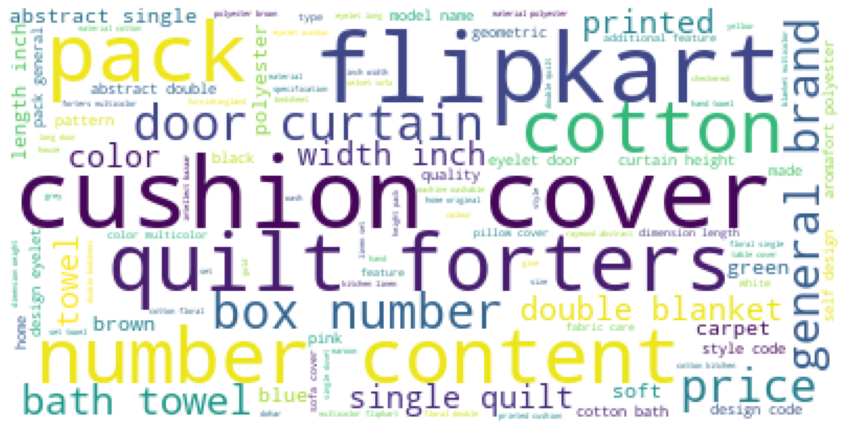

---- Baby Care ----


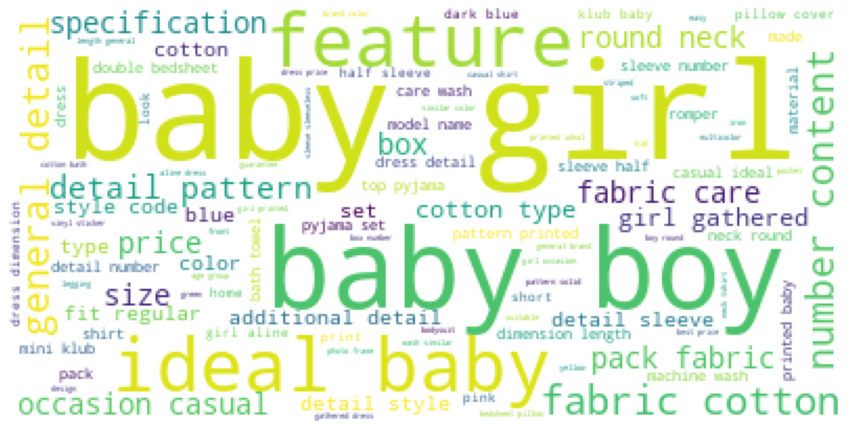

---- Watches  ----


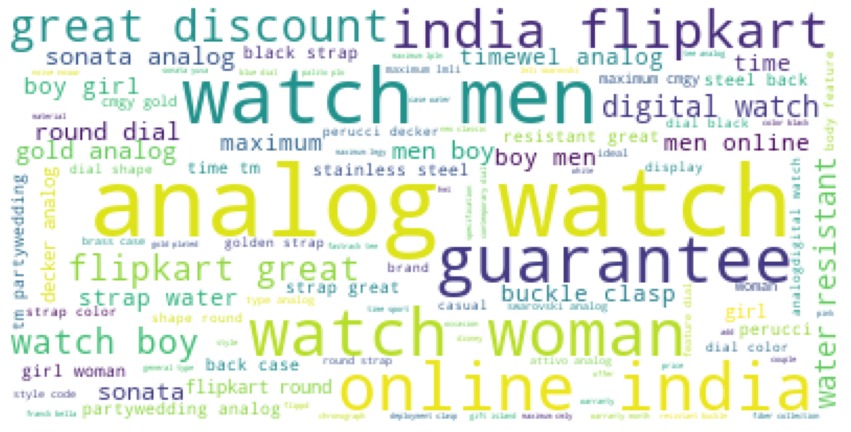

---- Home Decor ----


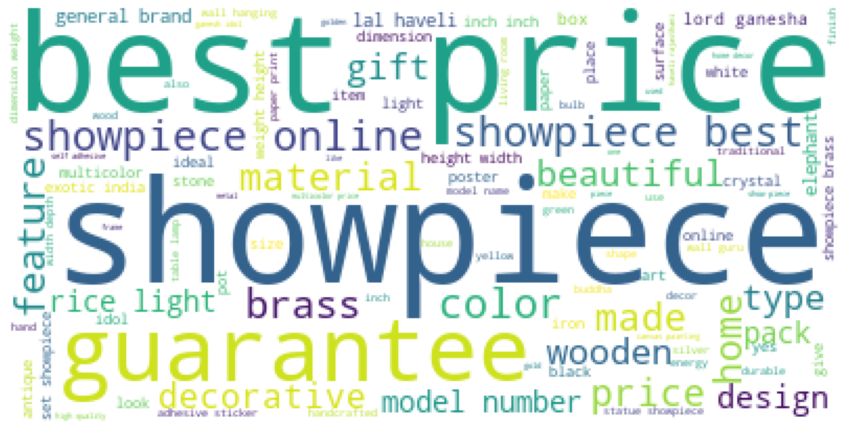

---- Kitchen  ----


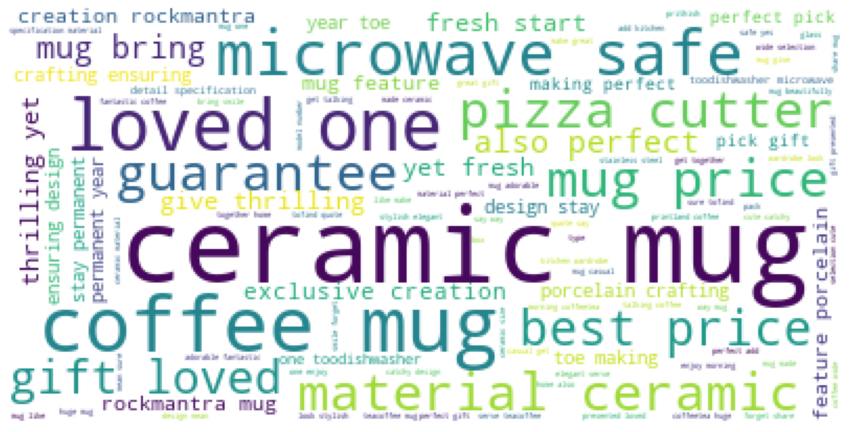

---- Beauty and ----


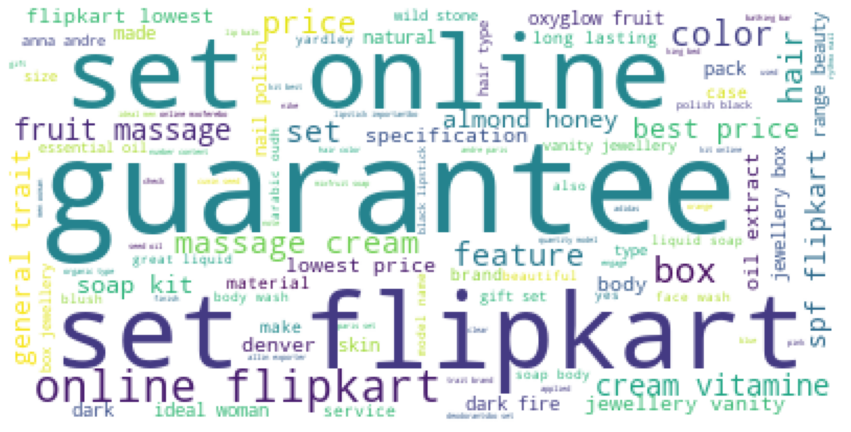

---- Computers  ----


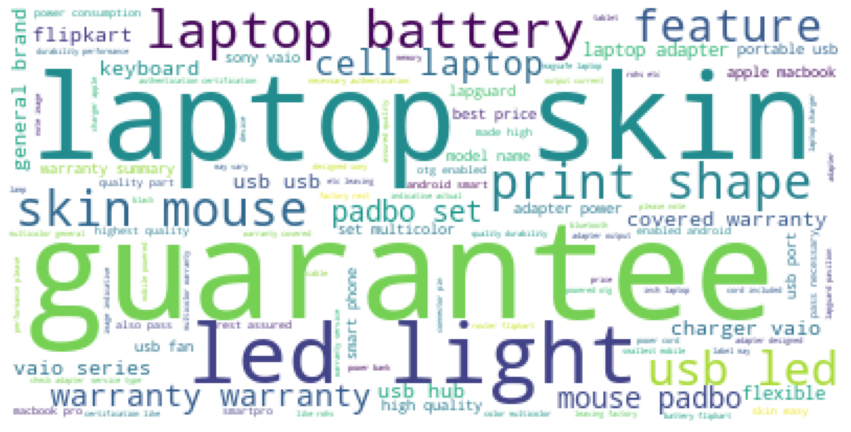

In [48]:
for label in df_cleaned_proc_lem['true_label'].unique() :
    
    df = df_cleaned_proc_lem[df_cleaned_proc_lem.true_label == label]
    corpus = " ".join(df.txt_clean_lem)
    plt.figure(figsize = (15, 15))
    wordcloud = WordCloud(background_color = 'white',
                          stopwords = ['shipping', 'cash', 'free', 'delivery', 'genuine', 'price'
                                      'guarantee', 'product', 'day', 'replacement', 'sale', 'package',
                                      'key', 'features', 'on', 'products', 'buy'],
                          max_words = 100).generate(corpus)

    print('----', label, '----')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()